# CDS503 - Machine Learning Final Project

Semester 2, Academic Session 2019/2020

Group 6 - **Data Masters**

Members:
- Lee Yong Meng
- Lee Kar Choon
- Tan Wei Chean
- Yee Hoong Yip

## Overview

- [Data Preparation](#Data-Preparation)
- [Experiment Set 1: Machine Learning Algorithm](#Experiment-Set-1:-Comparing-Machine-Learning-Algorithms)
- [Experiment Set 2: Feature Selection](#Experiment-Set-2:-Feature-Selection)
- [Experiment Set 3: Ensemble Learning](#Experiment-Set-3:-Ensemble-Learning)
  - [3.0 Default Classifiers](#3.0-Default-Classifiers)
  - [3.1 Bagging](#3.1-Bagging)
  - [3.2 Boosting](#3.2-Boosting)
  - [3.3 Voting](#3.3-Voting)
- [Experiment Set 4: Training Sample Size](#Experiment-Set-4:-Vary-Training-Sample-Size)

# Data Preparation

Before working on the experiment sets, we need to import some necessary libraries for working on data pre-processing and conducting experiment sets.

In [185]:
# Standard Python libraries
import pandas as pd                  # Use pandas.DataFrame to manipulate data
import matplotlib.pyplot as plt      # Standard plotting library
import numpy as np                   # Standard Python library for numerical operations

# Data preprocessing
from sklearn import preprocessing    # Data preprocessing

# Model selection - split data, cv, model evaluation
from sklearn.model_selection import train_test_split    # Split dataset into training and test sets
from sklearn.model_selection import cross_val_score     # k-fold cross-validation
from sklearn.model_selection import GridSearchCV        # search for best parameters
from sklearn import metrics                             # metrics to evaluate the model performance
from sklearn.metrics import classification_report, confusion_matrix    # analyze prediction made by the classification model

# Machine learning algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

# Feature extraction - Decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis

# Ensemble learning methods
# --- Bagging
from sklearn.ensemble import BaggingClassifier            # Bagging - (B)ootstrap (AGG)regat(ING)
from sklearn.ensemble import RandomForestClassifier       # Random Forest
# --- Boosting
from sklearn.ensemble import AdaBoostClassifier           # (ADA)ptive (BOOST)ing
from sklearn.ensemble import GradientBoostingClassifier   # Gradient Boosting
# --- Voting
from sklearn.ensemble import VotingClassifier             # Voting

# Itertools - here, used to generate combinations of base classifiers for voting
import itertools

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Reading CSV file

Next, we read in the data.

In [3]:
# Read in data
df = pd.read_csv('AppleStore.csv')

# Quick view on the data
df.head()

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


Several columns in the datasets are not helpful in our work. Therefore, we will remove these columns.

- `Id`: App ID
- `track_name`: App name
- Unnamed: the first column, which is the count of the record.

We use the method `.drop()` to remove the specified columns.

In [4]:
# Define columns to drop
columns_drop = ['id', 'track_name']

# Drop columns
df.drop(columns_drop, axis = 1, inplace = True)
df.drop(df.columns[df.columns.str.contains('unnamed', case = False)], axis = 1, inplace = True)
df.head()

,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


## Grouping `user_rating` using `pd.cut()` 

For our business problem, we would like to group the column `user_rating` (i.e. our target column) into three groups, namely "Low", "Medium" and "High". We use the function `pd.cut()` to perform the binning. Then, we add a new column `user_rating_label` into the data frame, which will be shown at the very end when the data frame preview is scrolling horizontally.

In [5]:
df['user_rating_label'] = pd.cut(df['user_rating'], bins = 3, labels = ['Low', 'Medium', 'High'])
df.head()

,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,user_rating_label
0,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1,High
1,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1,High
2,100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1,High
3,128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1,High
4,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1,High


Next, we will drop two other columns:
- `user_rating`: no longer needed because we will be using the new column `user_rating_label` as the target of classification.
- `currency`: not helpful because it only has one unique value "USD" for all examples.

In [6]:
# Define columns to drop
columns_drop = ['user_rating', 'currency']

# Drop columns
df.drop(columns_drop, axis = 1, inplace = True)
df.head()

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,user_rating_label
0,100788224,3.99,21292,26,4.5,6.3.5,4+,Games,38,5,10,1,High
1,158578688,0.00,161065,26,3.5,8.2.2,4+,Productivity,37,5,23,1,High
2,100524032,0.00,188583,2822,4.5,5.0.0,4+,Weather,37,5,3,1,High
3,128512000,0.00,262241,649,4.5,5.10.0,12+,Shopping,37,5,9,1,High
4,92774400,0.00,985920,5320,5.0,7.5.1,4+,Reference,37,5,45,1,High


We further inspect the data by calling the method `.info()`

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7197 entries, 0 to 7196
Data columns (total 13 columns):
size_bytes           7197 non-null int64
price                7197 non-null float64
rating_count_tot     7197 non-null int64
rating_count_ver     7197 non-null int64
user_rating_ver      7197 non-null float64
ver                  7197 non-null object
cont_rating          7197 non-null object
prime_genre          7197 non-null object
sup_devices.num      7197 non-null int64
ipadSc_urls.num      7197 non-null int64
lang.num             7197 non-null int64
vpp_lic              7197 non-null int64
user_rating_label    7197 non-null category
dtypes: category(1), float64(2), int64(7), object(3)
memory usage: 682.0+ KB


We see that there is no missing values in our data.

Some of the columns contain `String` values which might not be compatible to certain machine learning algorithms that will be implemented in the subsequent sections. Therefore, we need to transform the data into labels encoded by numeric values (i.e., 0, 1, 2, ...).

## Label Encoding - Categorical Attributes

We use `sklearn.preprocessing.LabelEncoder()` to transform the following columns into numeric labels:
- `prime_genre`: contains 22 unique `String` values.
- `user_rating_label`: contains 3 unique `String` values ("Low", "Medium", "High")
- `cont_rating`: app content rating, contains 4 unique `String` values.
- `ver`: app version, contains 1590 unique `String` values.

In [8]:
# from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# Define names of columns selected for label encoding
col_categories = ["cont_rating", "prime_genre", "user_rating_label", "ver"]
col_num_unique_values = dict()

for col_name in col_categories:
    count = len(df[col_name].unique())
    col_num_unique_values[col_name] = count
    
#     print("Column name: {}\n>>> There are {} unique values.".format(col_name, count))    
    print("There are {} unique values of {}.".format(count, col_name))
    
    df[col_name] = le.fit_transform(df[col_name])
    df[col_name] = df[col_name].astype(str)

print()

df.info()

There are 4 unique values of cont_rating.
There are 23 unique values of prime_genre.
There are 3 unique values of user_rating_label.
There are 1590 unique values of ver.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7197 entries, 0 to 7196
Data columns (total 13 columns):
size_bytes           7197 non-null int64
price                7197 non-null float64
rating_count_tot     7197 non-null int64
rating_count_ver     7197 non-null int64
user_rating_ver      7197 non-null float64
ver                  7197 non-null object
cont_rating          7197 non-null object
prime_genre          7197 non-null object
sup_devices.num      7197 non-null int64
ipadSc_urls.num      7197 non-null int64
lang.num             7197 non-null int64
vpp_lic              7197 non-null int64
user_rating_label    7197 non-null object
dtypes: float64(2), int64(7), object(4)
memory usage: 731.1+ KB


In [9]:
df.head()

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,user_rating_label
0,100788224,3.99,21292,26,4.5,1379,2,7,38,5,10,1,0
1,158578688,0.00,161065,26,3.5,1514,2,15,37,5,23,1,0
2,100524032,0.00,188583,2822,4.5,1210,2,22,37,5,3,1,0
3,128512000,0.00,262241,649,4.5,1236,0,17,37,5,9,1,0
4,92774400,0.00,985920,5320,5.0,1472,2,16,37,5,45,1,0


Then, the data after data preprocessing is saved into a new CSV file.

In [10]:
# df.to_csv(r'AppleStore_preprocessed.csv', index = False, header = True)

## Defining Target and Features and Splitting Dataset

The attribute `user_rating_label` is chosen as the target throught the experiment sets. At this stage, all the other attributes are selected as the features used for predicting the `user_rating_label` to this classification problem.

In [11]:
# Target - `user_rating_label`
target = df['user_rating_label']

# Feature - all other attributes
features = df.drop('user_rating_label', axis = 1)

Finally, the dataset is split into training and test sets, with proportions of 80% and 20% respectively.

In [12]:
# from sklearn.model_selection import train_test_split    # Split dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

In [13]:
# Define helper function - to evaluate model performance. 
def test_model(estimator, x_train, x_test, y_train, y_test, score="accuracy", average=None, clf_report=False):
    # Function within function #1
    # ---
    # Print model performance based on user-specified metric and average
    def test_scoring(y_test, y_pred, score="accuracy", average=None):
        score_lower = score.lower()
        score_metric = 0

        if average is None:
            average = "weighted"
            
        if score_lower == "accuracy":
            score_metric = metrics.accuracy_score(y_test, y_pred)
        elif score_lower == "precision":
            score_metric = metrics.precision_score(y_test, y_pred, average=average)
        elif score_lower == "recall":
            score_metric = metrics.recall_score(y_test, y_pred, average=average)
        elif score_lower == "f1_score":
            score_metric = metrics.f1_score(y_test, y_pred, average=average)
            
        score_name = ""
        
        if score_lower != "accuracy":
            score_name += average.capitalize() + " "
        
        score_name += score.capitalize()

        print("{} (Test):".format(score_name), end=' ')
        print("{:.4f}".format(score_metric))
        
        return {"name": score_name, "score": score_metric}
        
    
    # Function within function #2
    # ---
    # Print model performance report - confusion matrix and classification report
    def test_clf_report(y_test, y_pred):
        print("Confusion matrix:\n---")
        print(confusion_matrix(y_test, y_pred))
        print("\nClassification report:\n---")
        print(classification_report(y_test, y_pred))
    
    # ---
    
    # Training - fit training set into the estimator
    estimator.fit(x_train, y_train)
    
    # Testing - Predict the outcome/label
    y_predict = estimator.predict(x_test)
    
    # Print model performance - single metric
    dict_scoring = test_scoring(y_test, y_predict, score, average)
    
    # Print model performance report (optional)
    if clf_report:
        print()
        test_clf_report(y_test, y_predict)
        
    return dict_scoring

In [211]:
# Helper function to deal with repetitive processes
def train_and_evaluate(estimators, X_train, X_test, Y_train, Y_test):
    def get_scoring_metric():
#         return ['f1_macro', 'f1_weighted', 'accuracy']
        return ['f1_macro']
    
    # K-fold cross validation
    def print_validation_performance(estimator, X_train, Y_train, name=None, cv=10):
        for metric in get_scoring_metric():
            scores = cross_val_score(estimator, X_train, Y_train, cv=cv, scoring=metric)
            estimator_name = ""
            
            if name is not None:
                estimator_name = " {}".format(name)
                
            print("{} (Validation{}) = ".format(metric, estimator_name), end="")
            print("{:.4f}".format(scores.mean()))
    
    # Training and testing
    def print_test_performance(estimator, X_train, X_test, Y_train, Y_test, name=None):
        estimator.fit(X_train, Y_train)
        test_predict = estimator.predict(X_test)
        
        dict_score = {}
        
        for metric in get_scoring_metric():
            estimator_name = ""
            score = 0.0
            
            if name is not None:
                estimator_name = " {}".format(name) 
            
            average = None
            acc_flag = True
            
            if "macro" in metric:
                average = "macro"
                acc_flag = False
            elif "weighted" in metric:
                average = "weighted"
                acc_flag = False
            
            print("{} (Test{}) = ".format(metric, estimator_name), end="")
            
            if acc_flag:
                score = metrics.accuracy_score(Y_test, test_predict)
#                 print("{:.4f}".format(metrics.accuracy_score(Y_test, test_predict)))
            else:
                score = metrics.f1_score(Y_test, test_predict, average=average)
#                 print("{:.4f}".format(metrics.f1_score(Y_test, test_predict, average=average)))
            
            print("{:.4f}".format(score))
            
            dict_score[metric] = score
        
        print(confusion_matrix(Y_test, test_predict))
        print(classification_report(Y_test, test_predict))
        
        return dict_score
    
#     # Define estimators
#     estimators = {
#         "KNN": KNeighborsClassifier(n_neighbors=5),
#         "Decision Tree": DecisionTreeClassifier(random_state=0),
#         "SVM": SVC(kernel = 'poly', degree = 2, gamma = 'scale', max_iter=10000)
#     }
    
    dict_est_score = {}
    
    for key_est in estimators:
        print_validation_performance(estimators[key_est], X_train, Y_train, name=key_est)
        dict_est_score[key_est] = print_test_performance(estimators[key_est], 
                                                         X_train, X_test, Y_train, Y_test, 
                                                         name=key_est)
        print()
        
    return dict_est_score

Now that we are ready to conduct the experiment sets.

## Additional Step - Standard Scaling

This step is to standardize the features of the original dataset so that the values of each attribute has a mean, $\mu = 0$, and standard deviation, $\sigma = 1$.

**Note that the same step is performed on training and test features (i.e., `x_train` and `x_test`) separately to prevent _"data leakage"_. We do not want the information from the test set (e.g., outliers) to _leak_ into the training data.**

In [15]:
# === Obsolete ===

# Define helper function
def standardize_features(df):
    """
    Helper function to standardize the values of df so that the values of each attribute (column)
    has a mean value of 0 and standard deviation value of 1.
    
    Parameters
    ---
    df: specify a data frame which requires standardization on the values on each column.
    
    Return
    ---
    A data frame with standardized column values.
    """
    
    # Names of the features
    names = df.columns
    
    # Create the Scaler object
    scaler = preprocessing.StandardScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=names)
    
    return df_scaled

In [16]:
# Test helper function docstring (optional) :D
# help(standardize_features)

In [17]:
# Standard scaling on training features
scaled_x_train = standardize_features(x_train)

# Standard scaling on test features
scaled_x_test = standardize_features(x_test)

# Experiment Set 1: Comparing Machine Learning Algorithms

In [18]:
# Helper function - get the best parameter set for a classifier
def get_best_parameter_set(estimator, param_grid, scoring):
    # Fit on the dataset on all parameter combinations in param_grid
    # Retain the best combination
    grid_search = GridSearchCV(estimator, param_grid, cv=10, scoring=scoring) #f1_macro
    grid_result = grid_search.fit(x_train, y_train)
    
    return grid_result.best_params_

## 1.1 K-Nearest Neighbors

In [213]:
# Train and evaluate test performance of a baseline KNN classifier
estimator = {"KNN - baseline": KNeighborsClassifier()}

_ = train_and_evaluate(estimator, x_train, x_test, y_train, y_test)

f1_macro (Validation KNN - baseline) = 0.3262
f1_macro (Test KNN - baseline) = 0.3329
[[1062   30   10]
 [ 176   11    2]
 [ 141    4    4]]
              precision    recall  f1-score   support

           0       0.77      0.96      0.86      1102
           1       0.24      0.06      0.09       189
           2       0.25      0.03      0.05       149

    accuracy                           0.75      1440
   macro avg       0.42      0.35      0.33      1440
weighted avg       0.65      0.75      0.67      1440




In [20]:
param_grid = {'n_neighbors': range(2, 20)}

best_param_set = get_best_parameter_set(KNeighborsClassifier(), param_grid, scoring='f1_macro')
best_param_set

{'n_neighbors': 3}

In [21]:
# Train and evaluate test performance of a KNN classifier with the best parameter set
estimator = {"KNN - best parameter": KNeighborsClassifier(**best_param_set)}

train_and_evaluate(estimator, x_train, x_test, y_train, y_test)

f1_macro (Validation KNN - best parameter) = 0.3395
f1_weighted (Validation KNN - best parameter) = 0.6567
accuracy (Validation KNN - best parameter) = 0.7089

f1_macro (Test KNN - best parameter) = 0.3424
f1_weighted (Test KNN - best parameter) = 0.6667
accuracy (Test KNN - best parameter) = 0.7222
[[1017   54   31]
 [ 162   18    9]
 [ 137    7    5]]
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1102
           1       0.23      0.10      0.13       189
           2       0.11      0.03      0.05       149

    accuracy                           0.72      1440
   macro avg       0.37      0.35      0.34      1440
weighted avg       0.63      0.72      0.67      1440




## 1.2 Decision Trees

In [22]:
# Train and evaluate test performance of a baseline Decision Tree classifier
estimator = {"Decision Tree - baseline": DecisionTreeClassifier(random_state=0)}

train_and_evaluate(estimator, x_train, x_test, y_train, y_test)

f1_macro (Validation Decision Tree - baseline) = 0.7764
f1_weighted (Validation Decision Tree - baseline) = 0.8871
accuracy (Validation Decision Tree - baseline) = 0.8841

f1_macro (Test Decision Tree - baseline) = 0.7732
f1_weighted (Test Decision Tree - baseline) = 0.8801
accuracy (Test Decision Tree - baseline) = 0.8826
[[1025   15   62]
 [   4  180    5]
 [  77    6   66]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1102
           1       0.90      0.95      0.92       189
           2       0.50      0.44      0.47       149

    accuracy                           0.88      1440
   macro avg       0.77      0.78      0.77      1440
weighted avg       0.88      0.88      0.88      1440




In [23]:
param_grid = {'criterion': ['gini','entropy'],
              'splitter': ['best','random']}

best_param_set = get_best_parameter_set(DecisionTreeClassifier(random_state=0), param_grid, scoring='f1_macro')
best_param_set

{'criterion': 'gini', 'splitter': 'best'}

In [24]:
# Train and evaluate test performance of a Decision Tree classifier with the best parameter set
estimator = {"Decision Tree - best parameter": DecisionTreeClassifier(**best_param_set, random_state=0)}

train_and_evaluate(estimator, x_train, x_test, y_train, y_test)

f1_macro (Validation Decision Tree - best parameter) = 0.7764
f1_weighted (Validation Decision Tree - best parameter) = 0.8871
accuracy (Validation Decision Tree - best parameter) = 0.8841

f1_macro (Test Decision Tree - best parameter) = 0.7732
f1_weighted (Test Decision Tree - best parameter) = 0.8801
accuracy (Test Decision Tree - best parameter) = 0.8826
[[1025   15   62]
 [   4  180    5]
 [  77    6   66]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1102
           1       0.90      0.95      0.92       189
           2       0.50      0.44      0.47       149

    accuracy                           0.88      1440
   macro avg       0.77      0.78      0.77      1440
weighted avg       0.88      0.88      0.88      1440




## 1.3 Linear SVM

In [25]:
# Train and evaluate test performance of a baseline linear SVM classifier
estimator = {"Linear SVM - baseline": SVC(kernel='linear', max_iter=10000)}

train_and_evaluate(estimator, x_train, x_test, y_train, y_test)

f1_macro (Validation Linear SVM - baseline) = 0.1785
f1_weighted (Validation Linear SVM - baseline) = 0.3241
accuracy (Validation Linear SVM - baseline) = 0.3819

f1_macro (Test Linear SVM - baseline) = 0.1019
f1_weighted (Test Linear SVM - baseline) = 0.1081
accuracy (Test Linear SVM - baseline) = 0.1472
[[  68    0 1034]
 [   2    0  187]
 [   5    0  144]]
              precision    recall  f1-score   support

           0       0.91      0.06      0.12      1102
           1       0.00      0.00      0.00       189
           2       0.11      0.97      0.19       149

    accuracy                           0.15      1440
   macro avg       0.34      0.34      0.10      1440
weighted avg       0.70      0.15      0.11      1440




In [27]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

best_param_set = get_best_parameter_set(SVC(kernel='linear', max_iter=10000), param_grid, scoring='f1_macro')
best_param_set

{'C': 0.01}

In [29]:
# Train and evaluate test performance of a linear SVM classifier with the best parameter set
estimator = {"Linear SVM - best parameter": SVC(**best_param_set, kernel='linear', max_iter=10000)}

train_and_evaluate(estimator, x_train, x_test, y_train, y_test)

f1_macro (Validation Linear SVM - best parameter) = 0.1785
f1_weighted (Validation Linear SVM - best parameter) = 0.3241
accuracy (Validation Linear SVM - best parameter) = 0.3819

f1_macro (Test Linear SVM - best parameter) = 0.1019
f1_weighted (Test Linear SVM - best parameter) = 0.1081
accuracy (Test Linear SVM - best parameter) = 0.1472
[[  68    0 1034]
 [   2    0  187]
 [   5    0  144]]
              precision    recall  f1-score   support

           0       0.91      0.06      0.12      1102
           1       0.00      0.00      0.00       189
           2       0.11      0.97      0.19       149

    accuracy                           0.15      1440
   macro avg       0.34      0.34      0.10      1440
weighted avg       0.70      0.15      0.11      1440




## 1.4 Polynomial SVM

In [31]:
# Train and evaluate test performance of a baseline linear SVM classifier
estimator = {"Polynomial SVM - baseline": SVC(kernel='poly', max_iter=10000)}

train_and_evaluate(estimator, x_train, x_test, y_train, y_test)

f1_macro (Validation Polynomial SVM - baseline) = 0.2017
f1_weighted (Validation Polynomial SVM - baseline) = 0.4047
accuracy (Validation Polynomial SVM - baseline) = 0.4991

f1_macro (Test Polynomial SVM - baseline) = 0.2890
f1_weighted (Test Polynomial SVM - baseline) = 0.6634
accuracy (Test Polynomial SVM - baseline) = 0.7646
[[1101    0    1]
 [ 188    0    1]
 [ 149    0    0]]
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      1102
           1       0.00      0.00      0.00       189
           2       0.00      0.00      0.00       149

    accuracy                           0.76      1440
   macro avg       0.26      0.33      0.29      1440
weighted avg       0.59      0.76      0.66      1440




In [32]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'degree': [2, 3, 4], 
              'gamma': ['scale', 'auto', 0.001, 0.1, 1, 10, 100]}

best_param_set = get_best_parameter_set(SVC(kernel='poly', max_iter=10000), param_grid, scoring='f1_macro')
best_param_set

{'C': 0.1, 'degree': 4, 'gamma': 'scale'}

In [34]:
# Train and evaluate test performance of a polynomial SVM classifier with the best parameter set
estimator = {"Polynomial SVM - best parameter": SVC(**best_param_set, kernel='poly', max_iter=10000)}

train_and_evaluate(estimator, x_train, x_test, y_train, y_test)

f1_macro (Validation Polynomial SVM - best parameter) = 0.2887
f1_weighted (Validation Polynomial SVM - best parameter) = 0.6576
accuracy (Validation Polynomial SVM - best parameter) = 0.7598

f1_macro (Test Polynomial SVM - best parameter) = 0.0776
f1_weighted (Test Polynomial SVM - best parameter) = 0.0317
accuracy (Test Polynomial SVM - best parameter) = 0.1313
[[   1 1101    0]
 [   0  188    1]
 [   0  149    0]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1102
           1       0.13      0.99      0.23       189
           2       0.00      0.00      0.00       149

    accuracy                           0.13      1440
   macro avg       0.38      0.33      0.08      1440
weighted avg       0.78      0.13      0.03      1440




## 1.5 RBF SVM

In [46]:
# Train and evaluate test performance of a baseline linear SVM classifier
estimator = {"RBF SVM - baseline": SVC(kernel='rbf', max_iter=10000)}

train_and_evaluate(estimator, x_train, x_test, y_train, y_test)

f1_macro (Validation RBF SVM - baseline) = 0.2881
f1_weighted (Validation RBF SVM - baseline) = 0.6577
accuracy (Validation RBF SVM - baseline) = 0.7610

f1_macro (Test RBF SVM - baseline) = 0.2890
f1_weighted (Test RBF SVM - baseline) = 0.6635
accuracy (Test RBF SVM - baseline) = 0.7653
[[1102    0    0]
 [ 189    0    0]
 [ 149    0    0]]
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      1102
           1       0.00      0.00      0.00       189
           2       0.00      0.00      0.00       149

    accuracy                           0.77      1440
   macro avg       0.26      0.33      0.29      1440
weighted avg       0.59      0.77      0.66      1440




In [42]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'gamma': ['scale', 'auto', 0.001, 0.1, 1, 10, 100]}

best_param_set = get_best_parameter_set(SVC(kernel='rbf', max_iter=100), param_grid, scoring='f1_macro')
best_param_set

{'C': 0.01, 'gamma': 'scale'}

In [45]:
# Train and evaluate test performance of a polynomial SVM classifier with the best parameter set
estimator = {"RBF SVM - best parameter": SVC(**best_param_set, kernel='rbf', max_iter=10000)}

train_and_evaluate(estimator, x_train, x_test, y_train, y_test)

f1_macro (Validation RBF SVM - best parameter) = 0.2881
f1_weighted (Validation RBF SVM - best parameter) = 0.6577
accuracy (Validation RBF SVM - best parameter) = 0.7610

f1_macro (Test RBF SVM - best parameter) = 0.2890
f1_weighted (Test RBF SVM - best parameter) = 0.6635
accuracy (Test RBF SVM - best parameter) = 0.7653
[[1102    0    0]
 [ 189    0    0]
 [ 149    0    0]]
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      1102
           1       0.00      0.00      0.00       189
           2       0.00      0.00      0.00       149

    accuracy                           0.77      1440
   macro avg       0.26      0.33      0.29      1440
weighted avg       0.59      0.77      0.66      1440




## 1.6 Sigmoid SVM

In [47]:
# Train and evaluate test performance of a baseline linear SVM classifier
estimator = {"Sigmoid SVM - baseline": SVC(kernel='sigmoid', max_iter=10000)}

train_and_evaluate(estimator, x_train, x_test, y_train, y_test)

f1_macro (Validation Sigmoid SVM - baseline) = 0.2881
f1_weighted (Validation Sigmoid SVM - baseline) = 0.6577
accuracy (Validation Sigmoid SVM - baseline) = 0.7610

f1_macro (Test Sigmoid SVM - baseline) = 0.2890
f1_weighted (Test Sigmoid SVM - baseline) = 0.6635
accuracy (Test Sigmoid SVM - baseline) = 0.7653
[[1102    0    0]
 [ 189    0    0]
 [ 149    0    0]]
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      1102
           1       0.00      0.00      0.00       189
           2       0.00      0.00      0.00       149

    accuracy                           0.77      1440
   macro avg       0.26      0.33      0.29      1440
weighted avg       0.59      0.77      0.66      1440




In [48]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'gamma': ['scale', 'auto', 0.001, 0.1, 1, 10, 100]}

best_param_set = get_best_parameter_set(SVC(kernel='sigmoid', max_iter=100), param_grid, scoring='f1_macro')
best_param_set

{'C': 1, 'gamma': 'scale'}

In [49]:
# Train and evaluate test performance of a polynomial SVM classifier with the best parameter set
estimator = {"Sigmoid SVM - best parameter": SVC(**best_param_set, kernel='sigmoid', max_iter=10000)}

train_and_evaluate(estimator, x_train, x_test, y_train, y_test)

f1_macro (Validation Sigmoid SVM - best parameter) = 0.2881
f1_weighted (Validation Sigmoid SVM - best parameter) = 0.6577
accuracy (Validation Sigmoid SVM - best parameter) = 0.7610

f1_macro (Test Sigmoid SVM - best parameter) = 0.2890
f1_weighted (Test Sigmoid SVM - best parameter) = 0.6635
accuracy (Test Sigmoid SVM - best parameter) = 0.7653
[[1102    0    0]
 [ 189    0    0]
 [ 149    0    0]]
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      1102
           1       0.00      0.00      0.00       189
           2       0.00      0.00      0.00       149

    accuracy                           0.77      1440
   macro avg       0.26      0.33      0.29      1440
weighted avg       0.59      0.77      0.66      1440




# Experiment Set 2: Feature Selection 

In [51]:
# Define 3 different estimators
estimators = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "SVM": SVC(kernel = 'poly', degree = 2, gamma = 'scale', max_iter=10000)
}

In [78]:
def get_numeric_features(df, columns):
    df_num = df.copy()
    
    # Convert columns to type: int
    col_to_int = columns

    for col in col_to_int:
        df_num[col] = df_num[col].astype(int)
    
    return df_num

In [79]:
columns = ['ver', 'cont_rating', 'prime_genre']
x_train_num = get_numeric_features(x_train, columns=columns)
x_test_num = get_numeric_features(x_test, columns=columns)
x_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5757 entries, 5452 to 2732
Data columns (total 12 columns):
size_bytes          5757 non-null int64
price               5757 non-null float64
rating_count_tot    5757 non-null int64
rating_count_ver    5757 non-null int64
user_rating_ver     5757 non-null float64
ver                 5757 non-null int32
cont_rating         5757 non-null int32
prime_genre         5757 non-null int32
sup_devices.num     5757 non-null int64
ipadSc_urls.num     5757 non-null int64
lang.num            5757 non-null int64
vpp_lic             5757 non-null int64
dtypes: float64(2), int32(3), int64(7)
memory usage: 517.2 KB


## 2.1 Variance Threshold 

In [55]:
# Compute the variance of each column
x_train_num.var().sort_values(ascending=False)

size_bytes          1.387115e+17
rating_count_tot    5.946792e+09
rating_count_ver    1.727523e+07
ver                 1.926676e+05
lang.num            6.354421e+01
price               3.789444e+01
prime_genre         2.388685e+01
sup_devices.num     1.434726e+01
ipadSc_urls.num     3.967491e+00
user_rating_ver     3.287716e+00
cont_rating         7.888607e-01
vpp_lic             7.072274e-03
dtype: float64

In [56]:
# Define columns with Least variance
col_drop = ['vpp_lic', 'cont_rating', 'user_rating_ver', 'ipadSc_urls.num']

# Use 8 features with the highest variances
# - Drop columns with least variances from x_train_norm and x_test_norm
x_train_num.drop(col_drop, axis = 1, inplace = True)
x_test_num.drop(col_drop, axis = 1, inplace = True)

x_train_num.head()

,size_bytes,price,rating_count_tot,rating_count_ver,ver,prime_genre,sup_devices.num,lang.num
5452,79053824,0.00,14,3,298,7,38,1
3788,12320768,0.00,0,0,29,9,38,1
4381,539088896,0.00,89,2,649,7,38,11
3874,223020032,0.00,0,0,1115,7,38,1
3131,14583808,2.99,859,52,725,8,13,1


In [60]:
# Case 1: All features
train_and_evaluate(estimators, x_train, x_test, y_train, y_test)

f1_macro (Validation KNN) = 0.3262
f1_macro (Test KNN) = 0.3329
[[1062   30   10]
 [ 176   11    2]
 [ 141    4    4]]
              precision    recall  f1-score   support

           0       0.77      0.96      0.86      1102
           1       0.24      0.06      0.09       189
           2       0.25      0.03      0.05       149

    accuracy                           0.75      1440
   macro avg       0.42      0.35      0.33      1440
weighted avg       0.65      0.75      0.67      1440


f1_macro (Validation Decision Tree) = 0.7764
f1_macro (Test Decision Tree) = 0.7732
[[1025   15   62]
 [   4  180    5]
 [  77    6   66]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1102
           1       0.90      0.95      0.92       189
           2       0.50      0.44      0.47       149

    accuracy                           0.88      1440
   macro avg       0.77      0.78      0.77      1440
weighted avg       0.88      0.88 

In [61]:
# Case 2: 8 features
train_and_evaluate(estimators, x_train_num, x_test_num, y_train, y_test)

f1_macro (Validation KNN) = 0.3262
f1_macro (Test KNN) = 0.3329
[[1062   30   10]
 [ 176   11    2]
 [ 141    4    4]]
              precision    recall  f1-score   support

           0       0.77      0.96      0.86      1102
           1       0.24      0.06      0.09       189
           2       0.25      0.03      0.05       149

    accuracy                           0.75      1440
   macro avg       0.42      0.35      0.33      1440
weighted avg       0.65      0.75      0.67      1440


f1_macro (Validation Decision Tree) = 0.6608
f1_macro (Test Decision Tree) = 0.6726
[[979  16 107]
 [ 14 169   6]
 [110   4  35]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1102
           1       0.89      0.89      0.89       189
           2       0.24      0.23      0.24       149

    accuracy                           0.82      1440
   macro avg       0.67      0.67      0.67      1440
weighted avg       0.82      0.82      0.82

In [61]:
# Case 2: 8 features
train_and_evaluate(estimators, x_train_num, x_test_num, y_train, y_test)

f1_macro (Validation KNN) = 0.3262
f1_macro (Test KNN) = 0.3329
[[1062   30   10]
 [ 176   11    2]
 [ 141    4    4]]
              precision    recall  f1-score   support

           0       0.77      0.96      0.86      1102
           1       0.24      0.06      0.09       189
           2       0.25      0.03      0.05       149

    accuracy                           0.75      1440
   macro avg       0.42      0.35      0.33      1440
weighted avg       0.65      0.75      0.67      1440


f1_macro (Validation Decision Tree) = 0.6608
f1_macro (Test Decision Tree) = 0.6726
[[979  16 107]
 [ 14 169   6]
 [110   4  35]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1102
           1       0.89      0.89      0.89       189
           2       0.24      0.23      0.24       149

    accuracy                           0.82      1440
   macro avg       0.67      0.67      0.67      1440
weighted avg       0.82      0.82      0.82

In [62]:
# Compute the variance of each column
x_train_num.var().sort_values(ascending=False)

size_bytes          1.387115e+17
rating_count_tot    5.946792e+09
rating_count_ver    1.727523e+07
ver                 1.926676e+05
lang.num            6.354421e+01
price               3.789444e+01
prime_genre         2.388685e+01
sup_devices.num     1.434726e+01
dtype: float64

In [64]:
col_drop = ['sup_devices.num', 'prime_genre', 'price', 'lang.num']

x_train_num.drop(col_drop, axis=1, inplace=True)
x_test_num.drop(col_drop, axis=1, inplace=True)

x_train_num.head()

,size_bytes,rating_count_tot,rating_count_ver,ver
5452,79053824,14,3,298
3788,12320768,0,0,29
4381,539088896,89,2,649
3874,223020032,0,0,1115
3131,14583808,859,52,725


In [65]:
# Case 3: 4 features
train_and_evaluate(estimators, x_train_num, x_test_num, y_train, y_test)

f1_macro (Validation KNN) = 0.3262
f1_macro (Test KNN) = 0.3329
[[1062   30   10]
 [ 176   11    2]
 [ 141    4    4]]
              precision    recall  f1-score   support

           0       0.77      0.96      0.86      1102
           1       0.24      0.06      0.09       189
           2       0.25      0.03      0.05       149

    accuracy                           0.75      1440
   macro avg       0.42      0.35      0.33      1440
weighted avg       0.65      0.75      0.67      1440


f1_macro (Validation Decision Tree) = 0.6591
f1_macro (Test Decision Tree) = 0.6473
[[980  15 107]
 [ 17 167   5]
 [121   4  24]]
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1102
           1       0.90      0.88      0.89       189
           2       0.18      0.16      0.17       149

    accuracy                           0.81      1440
   macro avg       0.65      0.64      0.65      1440
weighted avg       0.81      0.81      0.81

## 2.2 Correlation

In [101]:
columns = ['ver', 'cont_rating', 'prime_genre', 'user_rating_label']
col_target = 'user_rating_label'

df_cor = df.copy()
df_cor = get_numeric_features(df_cor, columns=columns)

# Display correlation matrix
df_cor.corr()

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,user_rating_label
size_bytes,1.000000,0.182392,0.004486,0.006337,0.086075,-0.139159,-0.044634,-0.134438,-0.118347,0.152697,0.004614,-0.150418,-0.078687
price,0.182392,1.000000,-0.039044,-0.018012,0.025173,-0.010842,0.033551,-0.017413,-0.115361,0.066100,-0.006713,-0.029942,-0.048999
rating_count_tot,0.004486,-0.039044,1.000000,0.163645,0.088744,0.142502,-0.016398,0.039188,0.008832,0.015734,0.137675,-0.000982,-0.064099
rating_count_ver,0.006337,-0.018012,0.163645,1.000000,0.077840,-0.000678,-0.016948,0.011090,0.037951,0.024333,0.013287,0.006460,-0.049083
user_rating_ver,0.086075,0.025173,0.088744,0.077840,1.000000,-0.003986,0.090602,-0.033246,-0.018901,0.275737,0.175580,0.050094,-0.519424
ver,-0.139159,-0.010842,0.142502,-0.000678,-0.003986,1.000000,-0.110565,0.274150,-0.102288,-0.070954,0.137482,0.031991,-0.041580
cont_rating,-0.044634,0.033551,-0.016398,-0.016948,0.090602,-0.110565,1.000000,-0.052295,-0.047829,0.084674,0.024418,0.055412,-0.045117
prime_genre,-0.134438,-0.017413,0.039188,0.011090,-0.033246,0.274150,-0.052295,1.000000,-0.073675,-0.198290,0.104579,-0.028522,0.038696
sup_devices.num,-0.118347,-0.115361,0.008832,0.037951,-0.018901,-0.102288,-0.047829,-0.073675,1.000000,-0.037728,-0.041681,-0.037109,-0.013138
ipadSc_urls.num,0.152697,0.066100,0.015734,0.024333,0.275737,-0.070954,0.084674,-0.198290,-0.037728,1.000000,0.088378,0.071901,-0.228352


In [91]:
def get_correlated_features(df, col_target, threshold):
    # Generate correlation matrix
    cor = df.corr()
    
    # Correlation with target
    # Apply abs() to get the absolute value so no need to deal with negative correlations
    cor_target = abs(cor[col_target])
    
    # Select highly correlated features, with threshold
    relevant_features = cor_target[cor_target > threshold]
    
    # Get names of the features which are highly correlated to the target. 
    cols = [col for col in relevant_features.index if col.lower() != col_target.lower()]
    
    return cols

In [92]:
# Case 1: Threshold = 0.04
cols = get_correlated_features(df_cor, col_target, threshold=0.04)

x_train_cor = x_train[cols]
x_test_cor = x_test[cols]

x_train_cor.head()

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating_ver,ver,cont_rating,ipadSc_urls.num,lang.num,vpp_lic
5452,79053824,0.00,14,3,2.5,298,2,4,1,1
3788,12320768,0.00,0,0,0.0,29,2,5,1,1
4381,539088896,0.00,89,2,5.0,649,2,5,11,1
3874,223020032,0.00,0,0,0.0,1115,2,5,1,1
3131,14583808,2.99,859,52,3.0,725,2,0,1,1
...,...,...,...,...,...,...,...,...,...,...
4931,82688000,0.00,7518,643,4.5,760,0,5,2,1
3264,70754304,0.00,1147,1147,4.5,80,0,5,1,1
1653,72671232,0.99,11000,935,4.5,260,2,5,13,1
2607,118107136,0.00,4126,10,4.5,1079,0,0,25,1


In [94]:
# Training and evaluating using 10 features with correlation with target > 0.04
train_and_evaluate(estimators, x_train_cor, x_test_cor, y_train, y_test)

f1_macro (Validation KNN) = 0.3262
f1_macro (Test KNN) = 0.3329
[[1062   30   10]
 [ 176   11    2]
 [ 141    4    4]]
              precision    recall  f1-score   support

           0       0.77      0.96      0.86      1102
           1       0.24      0.06      0.09       189
           2       0.25      0.03      0.05       149

    accuracy                           0.75      1440
   macro avg       0.42      0.35      0.33      1440
weighted avg       0.65      0.75      0.67      1440


f1_macro (Validation Decision Tree) = 0.7750
f1_macro (Test Decision Tree) = 0.7636
[[1025    9   68]
 [   4  180    5]
 [  80    8   61]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1102
           1       0.91      0.95      0.93       189
           2       0.46      0.41      0.43       149

    accuracy                           0.88      1440
   macro avg       0.76      0.76      0.76      1440
weighted avg       0.87      0.88 

In [95]:
# Case 2: threshold = 0.05
cols = get_correlated_features(df_cor, col_target, threshold=0.05)

x_train_cor = x_train[cols]
x_test_cor = x_test[cols]

x_train_cor.head()

,size_bytes,rating_count_tot,user_rating_ver,ipadSc_urls.num,lang.num,vpp_lic
5452,79053824,14,2.5,4,1,1
3788,12320768,0,0.0,5,1,1
4381,539088896,89,5.0,5,11,1
3874,223020032,0,0.0,5,1,1
3131,14583808,859,3.0,0,1,1
...,...,...,...,...,...,...
4931,82688000,7518,4.5,5,2,1
3264,70754304,1147,4.5,5,1,1
1653,72671232,11000,4.5,5,13,1
2607,118107136,4126,4.5,0,25,1


In [96]:
# Training and evaluating using 10 features with correlation with target > 0.05
train_and_evaluate(estimators, x_train_cor, x_test_cor, y_train, y_test)

f1_macro (Validation KNN) = 0.3268
f1_macro (Test KNN) = 0.3300
[[1062   30   10]
 [ 177   10    2]
 [ 141    4    4]]
              precision    recall  f1-score   support

           0       0.77      0.96      0.86      1102
           1       0.23      0.05      0.09       189
           2       0.25      0.03      0.05       149

    accuracy                           0.75      1440
   macro avg       0.42      0.35      0.33      1440
weighted avg       0.64      0.75      0.67      1440


f1_macro (Validation Decision Tree) = 0.7601
f1_macro (Test Decision Tree) = 0.7525
[[1021    5   76]
 [   4  178    7]
 [  93    1   55]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1102
           1       0.97      0.94      0.95       189
           2       0.40      0.37      0.38       149

    accuracy                           0.87      1440
   macro avg       0.76      0.75      0.75      1440
weighted avg       0.87      0.87 

In [99]:
# Case 3: threshold = 0.1
cols = get_correlated_features(df_cor, col_target, threshold=0.1)

x_train_cor = x_train[cols]
x_test_cor = x_test[cols]

x_train_cor.head()

,user_rating_ver,ipadSc_urls.num,lang.num
5452,2.5,4,1
3788,0.0,5,1
4381,5.0,5,11
3874,0.0,5,1
3131,3.0,0,1
...,...,...,...
4931,4.5,5,2
3264,4.5,5,1
1653,4.5,5,13
2607,4.5,0,25


In [100]:
# Training and evaluating using 10 features with correlation with target > 0.1
train_and_evaluate(estimators, x_train_cor, x_test_cor, y_train, y_test)

f1_macro (Validation KNN) = 0.6846
f1_macro (Test KNN) = 0.6373
[[1014   46   42]
 [  74  113    2]
 [  86   15   48]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1102
           1       0.65      0.60      0.62       189
           2       0.52      0.32      0.40       149

    accuracy                           0.82      1440
   macro avg       0.68      0.61      0.64      1440
weighted avg       0.80      0.82      0.80      1440


f1_macro (Validation Decision Tree) = 0.7049
f1_macro (Test Decision Tree) = 0.6856
[[999  69  34]
 [ 17 169   3]
 [ 80  23  46]]
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1102
           1       0.65      0.89      0.75       189
           2       0.55      0.31      0.40       149

    accuracy                           0.84      1440
   macro avg       0.70      0.70      0.69      1440
weighted avg       0.84      0.84      0.84

## 2.3 Chi-Squared 

In [107]:
# columns = ['ver', 'cont_rating', 'prime_genre']
# x_train_num = get_numeric_features(x_train, columns=columns)
# x_test_num = get_numeric_features(x_test, columns=columns)
# x_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5757 entries, 5452 to 2732
Data columns (total 12 columns):
size_bytes          5757 non-null int64
price               5757 non-null float64
rating_count_tot    5757 non-null int64
rating_count_ver    5757 non-null int64
user_rating_ver     5757 non-null float64
ver                 5757 non-null int32
cont_rating         5757 non-null int32
prime_genre         5757 non-null int32
sup_devices.num     5757 non-null int64
ipadSc_urls.num     5757 non-null int64
lang.num            5757 non-null int64
vpp_lic             5757 non-null int64
dtypes: float64(2), int32(3), int64(7)
memory usage: 517.2 KB


In [132]:
def get_chi2_features(X, Y, num_k=10):
    # Create a selector
    # Setting k: we want top k features
    selector = SelectKBest(chi2, k=num_k)
    
    x_new = selector.fit_transform(X, Y)
    col_index = selector.get_support(indices=True)
    
    cols = X.columns[col_index]
    
    return cols

In [175]:
# # Case 1: k = 10
# cols = get_chi2_features(x_train_num, y_train, num_k=10)

# x_train_chi2 = x_train_num[cols]
# x_test_chi2 = x_test_num[cols]

cols = get_chi2_features(x_train, y_train, num_k=10)

x_train_chi2 = x_train[cols]
x_test_chi2 = x_test[cols]

x_train_chi2.head()

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating_ver,ver,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num
5452,79053824,0.00,14,3,2.5,298,7,38,4,1
3788,12320768,0.00,0,0,0.0,29,9,38,5,1
4381,539088896,0.00,89,2,5.0,649,7,38,5,11
3874,223020032,0.00,0,0,0.0,1115,7,38,5,1
3131,14583808,2.99,859,52,3.0,725,8,13,0,1


In [137]:
# Training and evaluating using top 10 features - chi2
train_and_evaluate(estimators, x_train_chi2, x_test_chi2, y_train, y_test)

f1_macro (Validation KNN) = 0.3262
f1_macro (Test KNN) = 0.3329
[[1062   30   10]
 [ 176   11    2]
 [ 141    4    4]]
              precision    recall  f1-score   support

           0       0.77      0.96      0.86      1102
           1       0.24      0.06      0.09       189
           2       0.25      0.03      0.05       149

    accuracy                           0.75      1440
   macro avg       0.42      0.35      0.33      1440
weighted avg       0.65      0.75      0.67      1440


f1_macro (Validation Decision Tree) = 0.7763
f1_macro (Test Decision Tree) = 0.7881
[[1036   15   51]
 [   5  182    2]
 [  78    4   67]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1102
           1       0.91      0.96      0.93       189
           2       0.56      0.45      0.50       149

    accuracy                           0.89      1440
   macro avg       0.80      0.78      0.79      1440
weighted avg       0.89      0.89 

In [176]:
# Case 2: k = 7
cols = get_chi2_features(x_train, y_train, num_k=7)

x_train_chi2 = x_train[cols]
x_test_chi2 = x_test[cols]

x_train_chi2.head()

,size_bytes,rating_count_tot,rating_count_ver,user_rating_ver,ver,ipadSc_urls.num,lang.num
5452,79053824,14,3,2.5,298,4,1
3788,12320768,0,0,0.0,29,5,1
4381,539088896,89,2,5.0,649,5,11
3874,223020032,0,0,0.0,1115,5,1
3131,14583808,859,52,3.0,725,0,1


In [139]:
# Training and evaluating using top 7 features - chi2
train_and_evaluate(estimators, x_train_chi2, x_test_chi2, y_train, y_test)

f1_macro (Validation KNN) = 0.3262
f1_macro (Test KNN) = 0.3329
[[1062   30   10]
 [ 176   11    2]
 [ 141    4    4]]
              precision    recall  f1-score   support

           0       0.77      0.96      0.86      1102
           1       0.24      0.06      0.09       189
           2       0.25      0.03      0.05       149

    accuracy                           0.75      1440
   macro avg       0.42      0.35      0.33      1440
weighted avg       0.65      0.75      0.67      1440


f1_macro (Validation Decision Tree) = 0.7785
f1_macro (Test Decision Tree) = 0.7581
[[1030    7   65]
 [   4  180    5]
 [  86    7   56]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1102
           1       0.93      0.95      0.94       189
           2       0.44      0.38      0.41       149

    accuracy                           0.88      1440
   macro avg       0.76      0.75      0.76      1440
weighted avg       0.87      0.88 

In [177]:
# Case 2: k = 4
cols = get_chi2_features(x_train, y_train, num_k=4)

x_train_chi2 = x_train[cols]
x_test_chi2 = x_test[cols]

x_train_chi2.head()

,size_bytes,rating_count_tot,rating_count_ver,ver
5452,79053824,14,3,298
3788,12320768,0,0,29
4381,539088896,89,2,649
3874,223020032,0,0,1115
3131,14583808,859,52,725


In [141]:
# Training and evaluating using top 4 features - chi2
train_and_evaluate(estimators, x_train_chi2, x_test_chi2, y_train, y_test)

f1_macro (Validation KNN) = 0.3262
f1_macro (Test KNN) = 0.3329
[[1062   30   10]
 [ 176   11    2]
 [ 141    4    4]]
              precision    recall  f1-score   support

           0       0.77      0.96      0.86      1102
           1       0.24      0.06      0.09       189
           2       0.25      0.03      0.05       149

    accuracy                           0.75      1440
   macro avg       0.42      0.35      0.33      1440
weighted avg       0.65      0.75      0.67      1440


f1_macro (Validation Decision Tree) = 0.6591
f1_macro (Test Decision Tree) = 0.6473
[[980  15 107]
 [ 17 167   5]
 [121   4  24]]
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1102
           1       0.90      0.88      0.89       189
           2       0.18      0.16      0.17       149

    accuracy                           0.81      1440
   macro avg       0.65      0.64      0.65      1440
weighted avg       0.81      0.81      0.81

## 2.4 Information Gain

In [142]:
def get_ig_features(X, Y, num_k=10):
    # Create a selector
    # Setting k: we want top k features
    selector = SelectKBest(mutual_info_classif, k=num_k)
    
    x_new = selector.fit_transform(X, Y)
    col_index = selector.get_support(indices=True)
    
    cols = X.columns[col_index]
    
    return cols

In [178]:
# Case 1: k = 10
cols = get_ig_features(x_train, y_train, num_k=10)

x_train_chi2 = x_train[cols]
x_test_chi2 = x_test[cols]

x_train_chi2.head()

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating_ver,ver,cont_rating,prime_genre,ipadSc_urls.num,lang.num
5452,79053824,0.00,14,3,2.5,298,2,7,4,1
3788,12320768,0.00,0,0,0.0,29,2,9,5,1
4381,539088896,0.00,89,2,5.0,649,2,7,5,11
3874,223020032,0.00,0,0,0.0,1115,2,7,5,1
3131,14583808,2.99,859,52,3.0,725,2,8,0,1


In [172]:
# Training and evaluating using top 10 features - information gain
train_and_evaluate(estimators, x_train_chi2, x_test_chi2, y_train, y_test)

f1_macro (Validation KNN) = 0.3262
f1_macro (Test KNN) = 0.3329
[[1062   30   10]
 [ 176   11    2]
 [ 141    4    4]]
              precision    recall  f1-score   support

           0       0.77      0.96      0.86      1102
           1       0.24      0.06      0.09       189
           2       0.25      0.03      0.05       149

    accuracy                           0.75      1440
   macro avg       0.42      0.35      0.33      1440
weighted avg       0.65      0.75      0.67      1440


f1_macro (Validation Decision Tree) = 0.7742
f1_macro (Test Decision Tree) = 0.7765
[[1025   11   66]
 [   5  180    4]
 [  76    6   67]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1102
           1       0.91      0.95      0.93       189
           2       0.49      0.45      0.47       149

    accuracy                           0.88      1440
   macro avg       0.78      0.78      0.78      1440
weighted avg       0.88      0.88 

In [179]:
# Case 2: k = 7
cols = get_ig_features(x_train, y_train, num_k=7)

x_train_chi2 = x_train[cols]
x_test_chi2 = x_test[cols]

x_train_chi2.head()

,size_bytes,rating_count_tot,rating_count_ver,user_rating_ver,prime_genre,ipadSc_urls.num,lang.num
5452,79053824,14,3,2.5,7,4,1
3788,12320768,0,0,0.0,9,5,1
4381,539088896,89,2,5.0,7,5,11
3874,223020032,0,0,0.0,7,5,1
3131,14583808,859,52,3.0,8,0,1


In [168]:
# Training and evaluating using top 7 features - information gain
train_and_evaluate(estimators, x_train_chi2, x_test_chi2, y_train, y_test)

f1_macro (Validation KNN) = 0.6161
f1_macro (Test KNN) = 0.6286
[[1054   19   29]
 [  14  175    0]
 [ 134    8    7]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.91      1102
           1       0.87      0.93      0.90       189
           2       0.19      0.05      0.08       149

    accuracy                           0.86      1440
   macro avg       0.65      0.64      0.63      1440
weighted avg       0.80      0.86      0.83      1440


f1_macro (Validation Decision Tree) = 0.7691
f1_macro (Test Decision Tree) = 0.7641
[[1020   16   66]
 [   2  180    7]
 [  78    7   64]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1102
           1       0.89      0.95      0.92       189
           2       0.47      0.43      0.45       149

    accuracy                           0.88      1440
   macro avg       0.76      0.77      0.76      1440
weighted avg       0.87      0.88 

In [184]:
# Case 3: k = 4
cols = get_ig_features(x_train, y_train, num_k=4)

x_train_chi2 = x_train[cols]
x_test_chi2 = x_test[cols]

x_train_chi2.head()

,rating_count_tot,rating_count_ver,user_rating_ver,lang.num
5452,14,3,2.5,1
3788,0,0,0.0,1
4381,89,2,5.0,11
3874,0,0,0.0,1
3131,859,52,3.0,1


In [174]:
# Training and evaluating using top 4 features - information gain
train_and_evaluate(estimators, x_train_chi2, x_test_chi2, y_train, y_test)

f1_macro (Validation KNN) = 0.6900
f1_macro (Test KNN) = 0.6653
[[1082    0   20]
 [   9  175    5]
 [ 138    1   10]]
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1102
           1       0.99      0.93      0.96       189
           2       0.29      0.07      0.11       149

    accuracy                           0.88      1440
   macro avg       0.72      0.66      0.67      1440
weighted avg       0.83      0.88      0.85      1440


f1_macro (Validation Decision Tree) = 0.7766
f1_macro (Test Decision Tree) = 0.7565
[[1024    2   76]
 [   5  183    1]
 [  92    4   53]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1102
           1       0.97      0.97      0.97       189
           2       0.41      0.36      0.38       149

    accuracy                           0.88      1440
   macro avg       0.76      0.75      0.76      1440
weighted avg       0.87      0.88 

## 2.5 Principal Component Analysis (PCA)

In [186]:
# Define helper function
def normalize_features(df):
    # Names of the features
    names = df.columns
    
    # Create the Scaler object
    normalizer = preprocessing.Normalizer()
    df_norm = normalizer.fit_transform(df)
    df_norm = pd.DataFrame(df_norm, columns=names)
    
    return df_norm

In [187]:
x_train_norm = normalize_features(x_train)
x_test_norm = normalize_features(x_test)

pca = PCA(n_components=3)
pca.fit(x_train_norm)

train_pca = pca.transform(x_train_norm)
test_pca = pca.transform(x_test_norm)

col_pca = ['PC1', 'PC2', 'PC3']

principalDf = pd.DataFrame(data=train_pca, columns=col_pca)
principalDf.head()

,PC1,PC2,PC3
0,-0.000158,-5.789039e-06,-0.000009
1,-0.000158,-5.936699e-06,-0.000010
2,-0.000158,-6.059672e-06,-0.000011
3,-0.000158,-5.713223e-06,-0.000007
4,-0.000099,8.565898e-07,0.000037


In [189]:
for num_pc in range(1, principalDf.shape[1]+1):
    print("Number of principal components: {}".format(num_pc))
    print("---")
    
    df_pca_train = pd.DataFrame(data = train_pca[:,:num_pc], columns = col_pca[:num_pc])
    df_pca_test = pd.DataFrame(data = test_pca[:,:num_pc], columns = col_pca[:num_pc])
  
    train_and_evaluate(estimators, df_pca_train, df_pca_test, y_train, y_test)

Number of principal components: 1
---
f1_macro (Validation KNN) = 0.5307
f1_macro (Test KNN) = 0.5241
[[1042   51    9]
 [  58  129    2]
 [ 140    9    0]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1102
           1       0.68      0.68      0.68       189
           2       0.00      0.00      0.00       149

    accuracy                           0.81      1440
   macro avg       0.51      0.54      0.52      1440
weighted avg       0.73      0.81      0.77      1440


f1_macro (Validation Decision Tree) = 0.2869
f1_macro (Test Decision Tree) = 0.2869
[[1088    1   13]
 [ 189    0    0]
 [ 149    0    0]]
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      1102
           1       0.00      0.00      0.00       189
           2       0.00      0.00      0.00       149

    accuracy                           0.76      1440
   macro avg       0.25      0.33      0.29      1

## 2.6 Factor Analysis

In [196]:
# Set the number of factors to 11
factor = FactorAnalysis(n_components = None, random_state = 101).fit(x_train_norm)
# Convert the factor loadings into a data frame
factor_df = pd.DataFrame(factor.components_, columns = x_train.columns)
factor_df

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,-1.729537e-06,1.096675e-07,0.000233,0.000008,1.479318e-07,3.603370e-05,1.208544e-07,7.572699e-07,2.383384e-06,1.417095e-07,1.969103e-07,6.244423e-08
1,-5.850639e-06,-2.720284e-08,0.000716,0.000014,-2.374795e-08,-6.612498e-06,-2.539387e-08,-2.045319e-07,-5.409411e-07,-2.928681e-08,-3.355409e-08,-1.430328e-08
2,2.488976e-07,-5.203757e-10,-0.000002,0.000011,2.284545e-09,-3.603155e-07,-3.209692e-10,-4.269422e-09,2.429558e-10,8.931404e-10,5.979289e-11,-8.504671e-11
3,0.000000e+00,-0.000000e+00,0.000000,0.000000,-0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00
4,0.000000e+00,0.000000e+00,0.000000,-0.000000,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,-0.000000e+00,0.000000e+00,-0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00
6,-0.000000e+00,0.000000e+00,-0.000000,0.000000,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00
7,0.000000e+00,0.000000e+00,0.000000,-0.000000,-0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00
8,-0.000000e+00,0.000000e+00,-0.000000,-0.000000,0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00
9,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00


In [199]:
columns = ['Factor 1', 'Factor 2', 'Factor 3']

x_train_factor = factor.fit_transform(x_train_norm)
x_test_factor = factor.fit_transform(x_test_norm)

x_train_factor = pd.DataFrame(data = x_train_factor[:,:3], columns = columns)
x_test_factor = pd.DataFrame(data = x_test_factor[:,:3], columns = columns)

x_train_factor.head()

,Factor 1,Factor 2,Factor 3
0,-0.202359,-0.055045,-0.016727
1,0.290771,-0.208415,-0.018769
2,-0.292407,-0.028512,-0.015958
3,-0.252034,-0.039544,-0.017033
4,0.243263,-0.141611,-0.019807


In [201]:
train_and_evaluate(estimators, x_train_factor, x_test_factor, y_train, y_test)

f1_macro (Validation KNN) = 0.4289
f1_macro (Test KNN) = 0.2213
[[413 688   1]
 [104  85   0]
 [ 84  64   1]]
              precision    recall  f1-score   support

           0       0.69      0.37      0.49      1102
           1       0.10      0.45      0.17       189
           2       0.50      0.01      0.01       149

    accuracy                           0.35      1440
   macro avg       0.43      0.28      0.22      1440
weighted avg       0.59      0.35      0.39      1440


f1_macro (Validation Decision Tree) = 0.4719
f1_macro (Test Decision Tree) = 0.2070
[[414   0 688]
 [110   0  79]
 [ 82   0  67]]
              precision    recall  f1-score   support

           0       0.68      0.38      0.48      1102
           1       0.00      0.00      0.00       189
           2       0.08      0.45      0.14       149

    accuracy                           0.33      1440
   macro avg       0.25      0.28      0.21      1440
weighted avg       0.53      0.33      0.39      144

# Experiment Set 3: Ensemble Learning

## 3.0 Default Classifiers

We start with a few selected classifiers with their respective default parameters without ensemble method.

In [244]:
# Define dictionary of classifiers
# max_iter - stopping criteria: to speed up the training process
# dict_clf_default = {
#     # --- clf_index: 0 - 4
#     "K-Nearest Neighbors": KNeighborsClassifier(), 
#     "Decision Tree": DecisionTreeClassifier(random_state=0), 
#     "Gaussian Naive Bayes": GaussianNB(), 
#     "Bernoulli Naive Bayes": BernoulliNB(), 
#     "Multinomial Naive Bayes": MultinomialNB(), 
#     # --- clf_index: 5 - 9
#     "Linear SVM": SVC(kernel='linear', max_iter=10000), 
#     "Polynomial SVM": SVC(kernel='poly', max_iter=10000), 
#     "RBF SVM": SVC(kernel='rbf', max_iter=10000), 
#     "Sigmoid SVM": SVC(kernel='sigmoid', max_iter=10000),
#     "Logistic Regression": LogisticRegression()
#    }


dict_clf_default = {
    "K-Nearest Neighbors": KNeighborsClassifier(), 
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Linear SVM": SVC(kernel='linear', max_iter=400), 
    "Polynomial SVM": SVC(kernel='poly', max_iter=400), 
    "RBF SVM": SVC(kernel='rbf', max_iter=400), 
    "Sigmoid SVM": SVC(kernel='sigmoid', max_iter=400),
    "Logistic Regression": LogisticRegression()
   }

Specify the `clf_index` from 0 - 9, each corresponding to the default classifier defined in `dict_clf_default`. 

Helper function `test_model()` is called to test the model test performance.

In [208]:
# Specify one classifier
clf_index = 1

estimator_name = list(dict_clf_default.keys())[clf_index]
estimator = {estimator_name: dict_clf_default[estimator_name]}

# # Print classifier name
# print("{}\n===".format(estimator_name))

# # Test using features with original Scale
# print("Original scale\n---")
# _ = test_model(estimator, x_train, x_test, y_train, y_test, 
#            score="f1_score", average="macro", clf_report=True)

# # Test using features with standardized scale
# print("\nStandardized scale\n---")
# _ = test_model(estimator, scaled_x_train, scaled_x_test, y_train, y_test, 
#            score="f1_score", average="macro", clf_report=True)

train_and_evaluate(estimator, x_train, x_test, y_train, y_test)

f1_macro (Validation Decision Tree) = 0.7764
f1_macro (Test Decision Tree) = 0.7732
[[1025   15   62]
 [   4  180    5]
 [  77    6   66]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1102
           1       0.90      0.95      0.92       189
           2       0.50      0.44      0.47       149

    accuracy                           0.88      1440
   macro avg       0.77      0.78      0.77      1440
weighted avg       0.88      0.88      0.88      1440




We can also compare the test performance of different models by using a `for` loop.

Then, initialize two list variables: `list_clf` and `list_score`. These two lists are used to store list of classifier names and model test performance respectively. These values are used to generate a CSV file and bar plot respectively.

Then, a horizontal barplot is generated to visualize the test performance by using the function `matplotlib.pyplot.barh()`.

f1_macro (Validation K-Nearest Neighbors) = 0.3262
f1_macro (Test K-Nearest Neighbors) = 0.3329
[[1062   30   10]
 [ 176   11    2]
 [ 141    4    4]]
              precision    recall  f1-score   support

           0       0.77      0.96      0.86      1102
           1       0.24      0.06      0.09       189
           2       0.25      0.03      0.05       149

    accuracy                           0.75      1440
   macro avg       0.42      0.35      0.33      1440
weighted avg       0.65      0.75      0.67      1440



f1_macro (Validation Decision Tree) = 0.7764
f1_macro (Test Decision Tree) = 0.7732
[[1025   15   62]
 [   4  180    5]
 [  77    6   66]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1102
           1       0.90      0.95      0.92       189
           2       0.50      0.44      0.47       149

    accuracy                           0.88      1440
   macro avg       0.77      0.78      0.77      1440
w

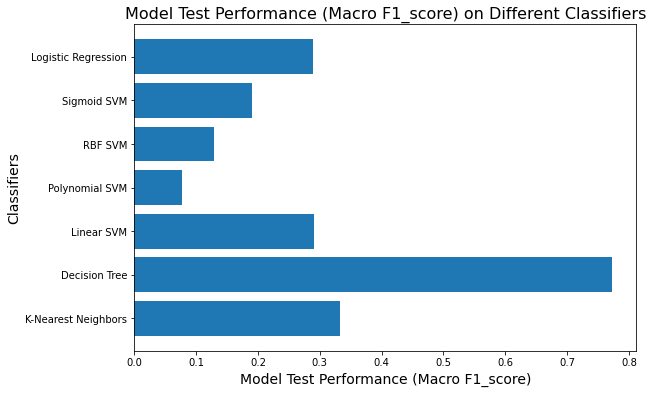

In [245]:
# Compare all classifiers
list_clf = []
list_score = []

score_param = "f1_score"
average_param = "macro"

feature_train = x_train
feature_test = x_test
# feature_train = scaled_x_train
# feature_test = scaled_x_test


# Generating results
# ---
# Iterate through all classifiers
for clf in dict_clf_default:
#     print("- {}".format(clf))
#     estimator = dict_clf_default[clf]
    
    estimator = { clf: dict_clf_default[clf] }
    try:
#         score = test_model(estimator, feature_train, feature_test, y_train, y_test,
#                       score=score_param, average=average_param)

        score = train_and_evaluate(estimator, feature_train, feature_test, y_train, y_test)
        
    except Exception as e:
        error_class_name = e.__class__.__name__
        print("{}: {}\n".format(error_class_name, e))
        continue
        
    print()
    
    list_clf.append(clf)
#     list_score.append(score[clf])
    list_score = list_score + list(score[clf].values())

    
# Create data frame
# ---
data = dict(classifier=list_clf, test_performance=list_score)
df_performance = pd.DataFrame(data=data)

# # Save and export df_performance to CSV file
# df_performance.to_csv(r'final_project_performance_default.csv', index = False, header = True)


# Plotting
# ---
str_x_label = "Model Test Performance ({} {})".format(average_param.capitalize(), score_param.capitalize())
font_size = 12

plt.figure(figsize=(9, 6))
plt.barh(list_clf, list_score)

plt.title("{} on Different Classifiers".format(str_x_label), fontsize=(font_size + 4))
plt.xlabel(str_x_label, fontsize=(font_size + 2))
plt.ylabel("Classifiers", fontsize=(font_size + 2))

plt.show()

# # Save plot into PNG (optional) 
# plt.savefig("final_project_performance_default.png", dpi=300, bbox_inches="tight")

In [228]:
print(list_score)

[{'f1_macro': 0.3328694504027031}, {'f1_macro': 0.7732013528151364}, {'f1_macro': 0.10192419135739424}, {'f1_macro': 0.28897637795275594}, {'f1_macro': 0.2890112772095463}, {'f1_macro': 0.2890112772095463}, {'f1_macro': 0.2890112772095463}]


## 3.1 Bagging

Recall the definition of `dict_clf_default` from the [earlier section](#3.0-Default-Classifiers).

In [20]:
_ = [print("Index: {} - {}".format(i, clf)) for i, clf in enumerate(dict_clf_default.keys())]

Index: 0 - K-Nearest Neighbors
Index: 1 - Decision Tree
Index: 2 - Gaussian Naive Bayes
Index: 3 - Bernoulli Naive Bayes
Index: 4 - Multinomial Naive Bayes
Index: 5 - Linear SVM
Index: 6 - Polynomial SVM
Index: 7 - RBF SVM
Index: 8 - Sigmoid SVM
Index: 9 - Logistic Regression


Specify the `clf_index` from 0 - 9 as a base classifier in bagging approach, each corresponding to the classifier defined in `dict_clf_default`.

In [233]:
# Specify classifier
clf_index = 1

base = list(dict_clf_default.values())[clf_index]
bagging_param = dict(base_estimator=base,
                     n_estimators=100,
                     random_state=0)

model_bagging = BaggingClassifier(**bagging_param)

estimator_name = "Bagging - {}".format(list(dict_clf_default.keys())[clf_index])
estimator = {estimator_name: model_bagging}

# # Print classifier name
# print("{}\n===".format(estimator_name))

# # Test using features with original Scale
# print("Original scale\n---")
# _ = test_model(model_bagging, x_train, x_test, y_train, y_test, 
#            score="f1_score", average="macro", clf_report=True)

# # Test using features with standardized scale
# print("\nStandardized scale\n---")
# _ = test_model(model_bagging, scaled_x_train, scaled_x_test, y_train, y_test, 
#            score="f1_score", average="macro", clf_report=True)

train_and_evaluate(estimator, x_train, x_test, y_train, y_test)

f1_macro (Validation Bagging - Decision Tree) = 0.8152
f1_macro (Test Bagging - Decision Tree) = 0.8090
[[1075    2   25]
 [   4  182    3]
 [  88    1   60]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1102
           1       0.98      0.96      0.97       189
           2       0.68      0.40      0.51       149

    accuracy                           0.91      1440
   macro avg       0.86      0.78      0.81      1440
weighted avg       0.90      0.91      0.91      1440




{'Bagging - Decision Tree': {'f1_macro': 0.8090483781836065}}

**Random forest** is another ensemble learning method. You can think of random forest as a collection of smaller (but different) trees (same machine learning algorithms) so it is included in the comparison with other *bagging* methods by specifying different base classifiers.

However, note that there are still some differences between *bagging* method and a *random forest* method. Click [here](https://stats.stackexchange.com/a/364453) for more.

In [234]:
# Specify classifier - Random Forest
random_forest_param = dict(
                     n_estimators=100,
                     random_state=0)

rf_clf = RandomForestClassifier(**random_forest_param)

estimator = {"Random Forest": rf_clf}

# # Print classifier name
# # print("{}\n===".format(estimator_name))
# print("Random Forest Classifier\n===")

# # Test using features with original Scale
# print("Original scale\n---")
# test_model(rf_clf, x_train, x_test, y_train, y_test, 
#            score="f1_score", average="macro", clf_report=True)

# # Test using features with standardized scale
# print("\nStandardized scale\n---")
# test_model(rf_clf, scaled_x_train, scaled_x_test, y_train, y_test, 
#            score="f1_score", average="macro", clf_report=True)

train_and_evaluate(estimator, x_train, x_test, y_train, y_test)

f1_macro (Validation Random Forest) = 0.8106
f1_macro (Test Random Forest) = 0.8103
[[1078    1   23]
 [   4  182    3]
 [  90    0   59]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1102
           1       0.99      0.96      0.98       189
           2       0.69      0.40      0.50       149

    accuracy                           0.92      1440
   macro avg       0.87      0.78      0.81      1440
weighted avg       0.91      0.92      0.91      1440




{'Random Forest': {'f1_macro': 0.8102923956188063}}

f1_macro (Validation K-Nearest Neighbors) = 0.3358
f1_macro (Test K-Nearest Neighbors) = 0.3292
[[1059   34    9]
 [ 176   10    3]
 [ 139    6    4]]
              precision    recall  f1-score   support

           0       0.77      0.96      0.86      1102
           1       0.20      0.05      0.08       189
           2       0.25      0.03      0.05       149

    accuracy                           0.75      1440
   macro avg       0.41      0.35      0.33      1440
weighted avg       0.64      0.75      0.67      1440



f1_macro (Validation Decision Tree) = 0.8152
f1_macro (Test Decision Tree) = 0.8090
[[1075    2   25]
 [   4  182    3]
 [  88    1   60]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1102
           1       0.98      0.96      0.97       189
           2       0.68      0.40      0.51       149

    accuracy                           0.91      1440
   macro avg       0.86      0.78      0.81      1440
w

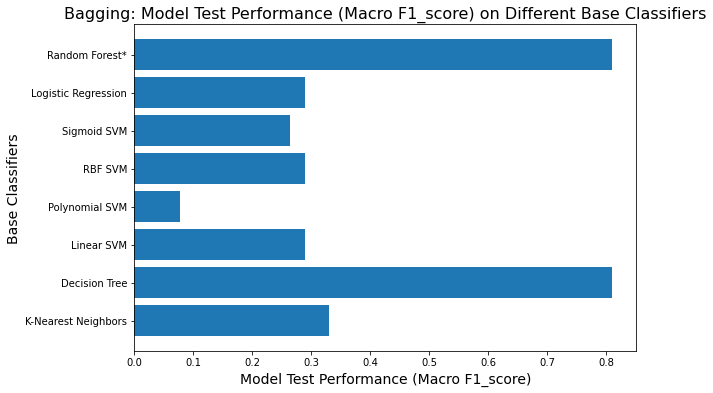

In [246]:
# Compare all classifiers
list_clf = []
list_score = []

score_param = "f1_score"
average_param = "macro"

feature_train = x_train
feature_test = x_test
# feature_train = scaled_x_train
# feature_test = scaled_x_test

bagging_param = dict(n_estimators=100, random_state=0)

# Loop through all classifiers
for i, clf in enumerate(dict_clf_default):
#     print("- {}".format(clf))
    base = dict_clf_default[clf]
    
    params = bagging_param.copy()
    params["base_estimator"] = base

    model_bagging = BaggingClassifier(**params)
    
    estimator = { clf: model_bagging }
    
    try:
#         score = test_model(model_bagging, feature_train, feature_test, y_train, y_test, 
#                            score=score_param, average=average_param)
        
        score = train_and_evaluate(estimator, feature_train, feature_test, y_train, y_test)
        
    except Exception as e:
        error_class_name = e.__class__.__name__
        print("{}: {}\n".format(error_class_name, e))
        continue
    
    print()
    
    list_clf.append(clf)
#     list_score.append(score["score"])
    list_score = list_score + list(score[clf].values())

# (Bonus) Random Forest classifier
model_rf = RandomForestClassifier(**bagging_param)

name_rf = "Random Forest*"
# print("- {}".format(name_rf))

# score_rf = test_model(model_rf, feature_train, feature_test, y_train, y_test,
#                       score=score_param, average=average_param)

estimator = { name_rf: model_rf }

score_rf = train_and_evaluate(estimator, feature_train, feature_test, y_train, y_test)

list_clf.append(name_rf)
# list_score.append(score_rf["score"])
list_score = list_score + list(score_rf[name_rf].values())

# Create data frame
data = dict(classifier=list_clf, test_performance=list_score)
df_performance = pd.DataFrame(data=data)

# # Save and export df_performance to CSV file
# df_performance.to_csv(r'final_project_performance_bagging.csv', index = False, header = True)

# Plotting for comparison
str_x_label = "Model Test Performance ({} {})".format(average_param.capitalize(), score_param.capitalize())
font_size = 12

plt.figure(figsize=(9, 6))
plt.barh(list_clf, list_score)

plt.title("Bagging: {} on Different Base Classifiers".format(str_x_label), fontsize=(font_size + 4))
plt.xlabel(str_x_label, fontsize=(font_size + 2))
plt.ylabel("Base Classifiers", fontsize=(font_size + 2))

plt.show()

# # Save plot into PNG (optional) 
# plt.savefig("final_project_performance_bagging.png", dpi=300, bbox_inches="tight")

## 3.2 Boosting

Recall the definition of `dict_clf_default` from the [earlier section](#3.0-Default-Classifiers).

In [247]:
_ = [print("Index: {} - {}".format(i, clf)) for i, clf in enumerate(dict_clf_default)]

Index: 0 - K-Nearest Neighbors
Index: 1 - Decision Tree
Index: 2 - Linear SVM
Index: 3 - Polynomial SVM
Index: 4 - RBF SVM
Index: 5 - Sigmoid SVM
Index: 6 - Logistic Regression


Specify the `clf_index` from 0 - 9 as a base classifier in AdaBoost approach, each corresponding to the classifier defined in `dict_clf_default`.

In [251]:
# Specify one classifier
clf_index = 1

# estimator_name = list(dict_clf_default.keys())[clf_index]
# estimator = list(dict_clf_default.values())[clf_index]
base = list(dict_clf_default.values())[clf_index]

boosting_param = dict(base_estimator=base,
                     n_estimators=100,
                     random_state=0)

model_boosting = AdaBoostClassifier(**boosting_param)

estimator_name = "Boosting - {}".format(list(dict_clf_default.keys())[clf_index])
estimator = {estimator_name: model_boosting}

# # Print classifier name
# print("{}\n===".format(estimator_name))

# # Test using features with original Scale
# print("Original scale\n---")
# test_model(model_boosting, x_train, x_test, y_train, y_test, 
#            score="f1_score", average="macro", clf_report=True)

# # Test using features with standardized scale
# print("\nStandardized scale\n---")
# test_model(model_boosting, scaled_x_train, scaled_x_test, y_train, y_test, 
#            score="f1_score", average="macro", clf_report=True)

train_and_evaluate(estimator, x_train, x_test, y_train, y_test)

f1_macro (Validation Boosting - Decision Tree) = 0.7783
f1_macro (Test Boosting - Decision Tree) = 0.7786
[[1035   18   49]
 [   4  180    5]
 [  79    5   65]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1102
           1       0.89      0.95      0.92       189
           2       0.55      0.44      0.49       149

    accuracy                           0.89      1440
   macro avg       0.79      0.78      0.78      1440
weighted avg       0.88      0.89      0.88      1440




{'Boosting - Decision Tree': {'f1_macro': 0.7786248020789598}}

Besides `AdaBoostClassifier`, there is also another boosting algorithms available in the `sklearn` library, which is  `GradientBoostingClassifier`.

For a **Gradient Boost** method, a base estimator is not required.

In [252]:
# Specify classifier - Gradient Boosting Classifier
gradient_boosting_param = dict(n_estimators=100, random_state=0)

model_boosting = GradientBoostingClassifier(**gradient_boosting_param)

estimator = {"Gradient Boosting": model_boosting}

# # Print classifier name
# print("Gradient Boosting\n===")

# # Test using features with original Scale
# print("Original scale\n---")
# test_model(model_boosting, x_train, x_test, y_train, y_test, 
#            score="f1_score", average="macro", clf_report=True)

# # Test using features with standardized scale
# print("\nStandardized scale\n---")
# test_model(model_boosting, scaled_x_train, scaled_x_test, y_train, y_test, 
#            score="f1_score", average="macro", clf_report=True)

train_and_evaluate(estimator, x_train, x_test, y_train, y_test)

f1_macro (Validation Gradient Boosting) = 0.8172
f1_macro (Test Gradient Boosting) = 0.8102
[[1072    0   30]
 [   5  181    3]
 [  86    1   62]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1102
           1       0.99      0.96      0.98       189
           2       0.65      0.42      0.51       149

    accuracy                           0.91      1440
   macro avg       0.86      0.78      0.81      1440
weighted avg       0.90      0.91      0.91      1440




{'Gradient Boosting': {'f1_macro': 0.8101721092165249}}

- K-Nearest Neighbors
f1_macro (Validation K-Nearest Neighbors) = nan
ValueError: KNeighborsClassifier doesn't support sample_weight.

- Decision Tree
f1_macro (Validation Decision Tree) = 0.7783
f1_macro (Test Decision Tree) = 0.7786
[[1035   18   49]
 [   4  180    5]
 [  79    5   65]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1102
           1       0.89      0.95      0.92       189
           2       0.55      0.44      0.49       149

    accuracy                           0.89      1440
   macro avg       0.79      0.78      0.78      1440
weighted avg       0.88      0.89      0.88      1440



- Linear SVM
f1_macro (Validation Linear SVM) = nan
TypeError: AdaBoostClassifier with algorithm='SAMME.R' requires that the weak learner supports the calculation of class probabilities with a predict_proba method.
Please change the base estimator or set algorithm='SAMME' instead.

- Polynomial SVM
f1_macro (Validation Polyno

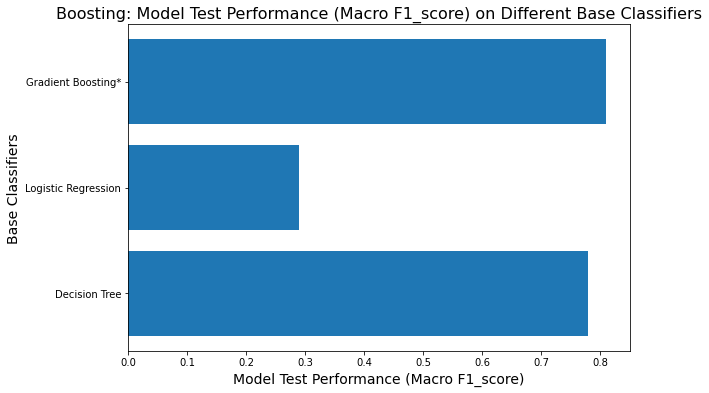

In [254]:
# Compare all classifiers
list_clf = []
list_score = []

# Specify model evaluation metric
score_param = "f1_score"
average_param = "macro"

feature_train = x_train
feature_test = x_test
# feature_train = scaled_x_train
# feature_test = scaled_x_test

# Initialize parameter values of boosting classifier
boosting_param = dict(n_estimators=100, random_state=0)

# Loop through all classifiers
# ---
for i, clf in enumerate(dict_clf_default):
    print("- {}".format(clf))
    base = dict_clf_default[clf]
    
    params = boosting_param.copy()
    params["base_estimator"] = base
    
    model_boosting = AdaBoostClassifier(**params)
    
    estimator = { clf: model_boosting }
    
    try:
        
#         score = test_model(model_boosting, feature_train, feature_test, y_train, y_test, 
#                            score=score_param, average=average_param)
        score = train_and_evaluate(estimator, x_train, x_test, y_train, y_test)
    
    except Exception as e:
        error_class_name = e.__class__.__name__
        print("{}: {}\n".format(error_class_name, e))
        continue
    
    print()
    
    list_clf.append(clf)
#     list_score.append(score["score"])
    list_score = list_score + list(score[clf].values())

# (Bonus) Gradient Boosting Classifier
# ---
model_gb = GradientBoostingClassifier(**boosting_param)

name_gb = "Gradient Boosting*"

estimator = {"Gradient Boosting*": model_gb}
# print("GradientBoostingClassifier\n===")
# print("- {}".format(name_gb))

score_gb = train_and_evaluate(estimator, x_train, x_test, y_train, y_test)

# score_gb = test_model(model_gb, feature_train, feature_test, y_train, y_test,
#                    score=score_param, average=average_param)

list_clf.append(name_gb)
list_score = list_score + list(score_gb[name_gb].values())

# Create data frame
# ---
data = dict(classifier=list_clf, test_performance=list_score)
df_performance = pd.DataFrame(data=data)

# # Save and export df_performance to CSV file
# df_performance.to_csv(r'final_project_performance_boosting.csv', index = False, header = True)

# Plotting
# ---
str_x_label = "Model Test Performance ({} {})".format(average_param.capitalize(), score_param.capitalize())
font_size = 12

plt.figure(figsize=(9, 6))
plt.barh(list_clf, list_score)

plt.title("Boosting: {} on Different Base Classifiers".format(str_x_label), fontsize=(font_size + 4))
plt.xlabel(str_x_label, fontsize=(font_size + 2))
plt.ylabel("Base Classifiers", fontsize=(font_size + 2))

plt.show()

# # Save plot into PNG (optional) 
# plt.savefig("final_project_performance_boosting.png", dpi=300, bbox_inches="tight")

## 3.3 Voting 

Voting is a method involving different machine learning algorithms.

To implement voting method, specify `num_base_clf`, the number of base classifiers when defining an object of `VotingClassifier()`.

In [256]:
# Specify model evaluation metrics
score_param = "f1_score"
average_param = "macro"

feature_train = x_train
feature_test = x_test
# feature_train = scaled_x_train
# feature_test = scaled_x_test

# specify number of base classifiers
num_base_clf = 3
list_clf = [[] for i in range(num_base_clf)]
list_score = []

# Generate all possible combinations of base classifiers with # of classifiers = num_base_clf
# For example: if num_base_clf = 4, 
# [A, B, C, D, E] -> [A, B, C, D], [A, B, C, E], [A, B, D, E], [A, C, D, E] and [B, C, D, E]
combinations_base_clf = itertools.combinations(dict_clf_default, num_base_clf)

# Loop through all generated lists
for comb in combinations_base_clf:
    list_base_clf = []
    
    # Return number of SVM and Naive Bayes classifiers in a list
    count_svm = sum("SVM" in clf for clf in comb)
    count_nb = sum("Naive Bayes" in clf for clf in comb)
    
    # At most one SVM classifiers and Naive Bayes classifiers in the list.
    # - skip all the lists with >1 SVM and >1 Naive Bayes classifiers - speed up looping process
    # - ensure variation in machine learning algorithms in the voting classifier
    if (count_svm <= 1) & (count_nb <= 1):
        for i, clf in enumerate(comb):
            list_base_clf.append((clf, dict_clf_default[clf]))
            list_clf[i].append(clf)
    
        print(comb)
        print("---")
        
        try:
            model_voting = VotingClassifier(estimators=list_base_clf)
#             score = test_model(model_voting, feature_train, feature_test, y_train, y_test, 
#                                score=score_param, average=average_param)
            
            estimator_name = "Voting Classifier"
            estimator = { estimator_name : model_voting }
            score = train_and_evaluate(estimator, x_train, x_test, y_train, y_test)
            
#             list_score.append(score["score"])
            list_score = list_score + list(score[estimator_name].values())
            
        except Exception as e:
            error_class_name = e.__class__.__name__
            print("{}: {}\n".format(error_class_name, e))
            continue
        
        print()

        
# Create data frame
# ---
data = dict()
for i, base_clf in enumerate(list_clf):
    clf_key = "classifier_{}".format(i)
    data[clf_key] = base_clf

data["test_performance"] = list_score
df_performance = pd.DataFrame(data=data)

# Save and export df_performance to CSV file
df_performance.to_csv(r'final_project_performance_voting_{}clf.csv'.format(num_base_clf), index = False, header = True)

df_performance

('K-Nearest Neighbors', 'Decision Tree', 'Linear SVM')
---
f1_macro (Validation Voting Classifier) = 0.4003
f1_macro (Test Voting Classifier) = 0.3423
[[1093    3    6]
 [ 178   11    0]
 [ 145    0    4]]
              precision    recall  f1-score   support

           0       0.77      0.99      0.87      1102
           1       0.79      0.06      0.11       189
           2       0.40      0.03      0.05       149

    accuracy                           0.77      1440
   macro avg       0.65      0.36      0.34      1440
weighted avg       0.74      0.77      0.68      1440



('K-Nearest Neighbors', 'Decision Tree', 'Polynomial SVM')
---
f1_macro (Validation Voting Classifier) = 0.4770
f1_macro (Test Voting Classifier) = 0.6034
[[1058   43    1]
 [   9  180    0]
 [ 136   10    3]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1102
           1       0.77      0.95      0.85       189
           2       0.75      0.02     

,classifier_0,classifier_1,classifier_2,test_performance
0,K-Nearest Neighbors,Decision Tree,Linear SVM,0.342279
1,K-Nearest Neighbors,Decision Tree,Polynomial SVM,0.603434
2,K-Nearest Neighbors,Decision Tree,RBF SVM,0.469199
3,K-Nearest Neighbors,Decision Tree,Sigmoid SVM,0.461199
4,K-Nearest Neighbors,Decision Tree,Logistic Regression,0.336290
5,K-Nearest Neighbors,Linear SVM,Logistic Regression,0.288863
6,K-Nearest Neighbors,Polynomial SVM,Logistic Regression,0.317549
7,K-Nearest Neighbors,RBF SVM,Logistic Regression,0.304613
8,K-Nearest Neighbors,Sigmoid SVM,Logistic Regression,0.304613
9,Decision Tree,Linear SVM,Logistic Regression,0.296304


# Experiment Set 4: Vary Training Sample Size

In [258]:
# Generate 10 subsamples from the original training set.
num_subsamples = 10

x_train_subs = []
y_train_subs = []

for k in range(num_subsamples - 1):
    x_train_sub, _, y_train_sub, _ = train_test_split(x_train, y_train, 
                                                      train_size=((k+1) / 10),
                                                      random_state=0)
    x_train_subs.append(x_train_sub)
    y_train_subs.append(y_train_sub)
    
x_train_subs.append(x_train)
y_train_subs.append(y_train)

In [257]:
# Define helper function
def train_and_evaluate_vary_size(estimator, x_train_list, x_test, y_train_list, y_test):
    # 2 - Train and evaluate
    # Initialize 3 empty lists to store the values of k and validation and test score 
    # Initialize 1 empty dictionary (scores) to store the k: validation_score / test_score (key:value) pairs
    K = [] 
    validationf1macro = []
    testf1macro = []
    scores = {}

    for k, (x_train, y_train) in enumerate(zip(x_train_list, y_train_list)):
        # 10-fold Cross-Validation
        # ---
        # Compute the validation score for the model using 10-fold cross validation 
        scores_val = cross_val_score(estimator, x_train, y_train, cv = 10, scoring = 'f1_macro')

        # Compute the mean validation score
        score_val_mean = scores_val.mean()

        # Training and testing
        # ---
        # Fit and train the model to the subsample training data.
        estimator.fit(x_train, y_train)

        # Compute the test score by compare the actual and prediction outcome.
        test_predict = estimator.predict(x_test)

        # Compute the test score by compare the actual and prediction outcome.
        score_test = metrics.f1_score(y_test, test_predict, average='macro')

        # Update lists
        # ---
        key = k + 1
        K.append(key)

        validationf1macro.append(score_val_mean)
        testf1macro.append(score_test)

        # A dictionary holds key: value pairs and Store the validation score for each value of k
        scores[key] = (score_val_mean, score_test)


    # 3 - Print result
    print("Subsample (%): Macro F1 score (Validation | Test)")

    for key_score in scores:
        score_val = scores[key_score][0]
        score_test = scores[key_score][1]
        print("{:.1f}%: ({:.4f} | {:.4f})".format(key_score*10, score_val, score_test))

## 4.1: Best Model from Experiment Set 1

In [259]:
# Define Decision Tree classifier
dtree = DecisionTreeClassifier(criterion = 'gini',splitter = 'best', random_state = 0)

train_and_evaluate_vary_size(dtree, x_train_subs, x_test, y_train_subs, y_test)

Subsample (%): Macro F1 score (Validation | Test)
10.0%: (0.7223 | 0.7347)
20.0%: (0.7465 | 0.7508)
30.0%: (0.7658 | 0.7499)
40.0%: (0.7678 | 0.7449)
50.0%: (0.7430 | 0.7449)
60.0%: (0.7744 | 0.7692)
70.0%: (0.7776 | 0.7757)
80.0%: (0.7815 | 0.7700)
90.0%: (0.7771 | 0.7692)
100.0%: (0.7764 | 0.7732)


## 4.2: Best Model from Experiment Set 2

In [261]:
cols = get_chi2_features(x_train, y_train, num_k=10)

x_train_chi2 = x_train[cols]
x_test_chi2 = x_test[cols]

x_train_sub_chi2 = []
for k in range(num_subsamples - 1):
    x_train_sub, _, _, _ = train_test_split(x_train, y_train,           
                                            train_size=((k+1) / 10),
                                            random_state=0)
    x_train_sub_chi2.append(x_train_sub)
#     y_train_subs.append(y_train_sub)
    
x_train_sub_chi2.append(x_train_chi2)
# y_train_subs.append(y_train)

In [262]:
# Training and evaluating using top 10 features - chi2
dtree = DecisionTreeClassifier(random_state=0)
train_and_evaluate_vary_size(dtree, x_train_subs, x_test, y_train_subs, y_test)

Subsample (%): Macro F1 score (Validation | Test)
10.0%: (0.7223 | 0.7347)
20.0%: (0.7465 | 0.7508)
30.0%: (0.7658 | 0.7499)
40.0%: (0.7678 | 0.7449)
50.0%: (0.7430 | 0.7449)
60.0%: (0.7744 | 0.7692)
70.0%: (0.7776 | 0.7757)
80.0%: (0.7815 | 0.7700)
90.0%: (0.7771 | 0.7692)
100.0%: (0.7764 | 0.7732)


## 4.3: Best Model from Experiment Set 3

In [260]:
# #Import the package for Bagging Classifier
# from sklearn.ensemble import BaggingClassifier

model_bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=0), 
                                  n_estimators = 100, random_state = 0)

train_and_evaluate_vary_size(model_bagging, x_train_subs, x_test, y_train_subs, y_test)

Subsample (%): Macro F1 score (Validation | Test)
10.0%: (0.7515 | 0.7899)
20.0%: (0.7898 | 0.8064)
30.0%: (0.8087 | 0.7952)
40.0%: (0.8044 | 0.8088)
50.0%: (0.8097 | 0.8167)
60.0%: (0.8079 | 0.8135)
70.0%: (0.8095 | 0.8132)
80.0%: (0.8119 | 0.8179)
90.0%: (0.8144 | 0.8031)
100.0%: (0.8152 | 0.8090)


The overall best model is the bagging model.